In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=True)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.0001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


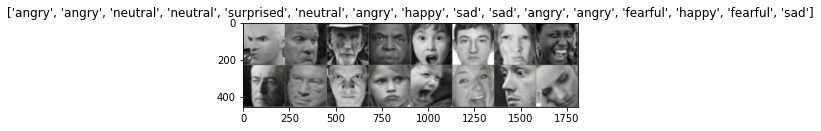

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr= 0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/1248], Loss: 12.5665
Epoch [1/100], Step [20/1248], Loss: 1.7986
Epoch [1/100], Step [40/1248], Loss: 1.7564
Epoch [1/100], Step [60/1248], Loss: 1.9362
Epoch [1/100], Step [80/1248], Loss: 1.7727
Epoch [1/100], Step [100/1248], Loss: 1.7726
Epoch [1/100], Step [120/1248], Loss: 1.7963
Epoch [1/100], Step [140/1248], Loss: 1.5297
Epoch [1/100], Step [160/1248], Loss: 1.8040
Epoch [1/100], Step [180/1248], Loss: 1.3248
Epoch [1/100], Step [200/1248], Loss: 1.5236
Epoch [1/100], Step [220/1248], Loss: 1.6529
Epoch [1/100], Step [240/1248], Loss: 1.7456
Epoch [1/100], Step [260/1248], Loss: 1.4531
Epoch [1/100], Step [280/1248], Loss: 1.9066
Epoch [1/100], Step [300/1248], Loss: 1.3632
Epoch [1/100], Step [320/1248], Loss: 1.3861
Epoch [1/100], Step [340/1248], Loss: 0.9668
Epoch [1/100], Step [360/1248], Loss: 1.1055
Epoch [1/100], Step [380/1248], Loss: 1.3828
Epoch [1/100], Step [400/1248], Loss: 1.3804
Epoch [1/100], Step [420/1248], Loss: 1.5017
Epoch 

Epoch [3/100], Step [1000/1248], Loss: 1.3809
Epoch [3/100], Step [1020/1248], Loss: 1.0284
Epoch [3/100], Step [1040/1248], Loss: 1.2691
Epoch [3/100], Step [1060/1248], Loss: 0.9566
Epoch [3/100], Step [1080/1248], Loss: 0.7799
Epoch [3/100], Step [1100/1248], Loss: 0.9394
Epoch [3/100], Step [1120/1248], Loss: 0.7179
Epoch [3/100], Step [1140/1248], Loss: 0.8776
Epoch [3/100], Step [1160/1248], Loss: 0.6698
Epoch [3/100], Step [1180/1248], Loss: 0.9261
Epoch [3/100], Step [1200/1248], Loss: 0.7168
Epoch [3/100], Step [1220/1248], Loss: 0.9944
Epoch [3/100], Step [1240/1248], Loss: 1.1245

train-loss: 1.1078, train-acc: 67.0341
validation loss: 0.9912, validation acc: 66.9196

Improvement-Detected, save-model
Epoch 4

Epoch [4/100], Step [0/1248], Loss: 0.7259
Epoch [4/100], Step [20/1248], Loss: 0.6908
Epoch [4/100], Step [40/1248], Loss: 0.7023
Epoch [4/100], Step [60/1248], Loss: 0.5233
Epoch [4/100], Step [80/1248], Loss: 0.6413
Epoch [4/100], Step [100/1248], Loss: 0.8169
Epoch 

Epoch [6/100], Step [720/1248], Loss: 0.4292
Epoch [6/100], Step [740/1248], Loss: 0.5107
Epoch [6/100], Step [760/1248], Loss: 0.6449
Epoch [6/100], Step [780/1248], Loss: 0.2379
Epoch [6/100], Step [800/1248], Loss: 0.2521
Epoch [6/100], Step [820/1248], Loss: 0.9065
Epoch [6/100], Step [840/1248], Loss: 0.2746
Epoch [6/100], Step [860/1248], Loss: 0.6751
Epoch [6/100], Step [880/1248], Loss: 0.5896
Epoch [6/100], Step [900/1248], Loss: 0.0862
Epoch [6/100], Step [920/1248], Loss: 0.7438
Epoch [6/100], Step [940/1248], Loss: 0.7523
Epoch [6/100], Step [960/1248], Loss: 0.1982
Epoch [6/100], Step [980/1248], Loss: 0.4683
Epoch [6/100], Step [1000/1248], Loss: 0.5617
Epoch [6/100], Step [1020/1248], Loss: 0.7711
Epoch [6/100], Step [1040/1248], Loss: 0.1277
Epoch [6/100], Step [1060/1248], Loss: 0.3682
Epoch [6/100], Step [1080/1248], Loss: 0.1855
Epoch [6/100], Step [1100/1248], Loss: 0.4275
Epoch [6/100], Step [1120/1248], Loss: 0.3695
Epoch [6/100], Step [1140/1248], Loss: 0.3604
Ep

Epoch [9/100], Step [440/1248], Loss: 0.2247
Epoch [9/100], Step [460/1248], Loss: 0.0933
Epoch [9/100], Step [480/1248], Loss: 0.3226
Epoch [9/100], Step [500/1248], Loss: 0.2297
Epoch [9/100], Step [520/1248], Loss: 0.1900
Epoch [9/100], Step [540/1248], Loss: 0.0657
Epoch [9/100], Step [560/1248], Loss: 0.9133
Epoch [9/100], Step [580/1248], Loss: 0.0313
Epoch [9/100], Step [600/1248], Loss: 0.4733
Epoch [9/100], Step [620/1248], Loss: 0.0916
Epoch [9/100], Step [640/1248], Loss: 0.2402
Epoch [9/100], Step [660/1248], Loss: 0.0826
Epoch [9/100], Step [680/1248], Loss: 0.1211
Epoch [9/100], Step [700/1248], Loss: 0.1297
Epoch [9/100], Step [720/1248], Loss: 0.1556
Epoch [9/100], Step [740/1248], Loss: 0.2881
Epoch [9/100], Step [760/1248], Loss: 0.1480
Epoch [9/100], Step [780/1248], Loss: 0.0563
Epoch [9/100], Step [800/1248], Loss: 0.0504
Epoch [9/100], Step [820/1248], Loss: 0.1201
Epoch [9/100], Step [840/1248], Loss: 0.0637
Epoch [9/100], Step [860/1248], Loss: 0.1459
Epoch [9/1

Epoch [12/100], Step [120/1248], Loss: 0.0607
Epoch [12/100], Step [140/1248], Loss: 0.0556
Epoch [12/100], Step [160/1248], Loss: 0.0096
Epoch [12/100], Step [180/1248], Loss: 0.0070
Epoch [12/100], Step [200/1248], Loss: 0.0612
Epoch [12/100], Step [220/1248], Loss: 0.0812
Epoch [12/100], Step [240/1248], Loss: 0.1096
Epoch [12/100], Step [260/1248], Loss: 0.1302
Epoch [12/100], Step [280/1248], Loss: 0.0394
Epoch [12/100], Step [300/1248], Loss: 0.0245
Epoch [12/100], Step [320/1248], Loss: 0.0235
Epoch [12/100], Step [340/1248], Loss: 0.0174
Epoch [12/100], Step [360/1248], Loss: 0.0405
Epoch [12/100], Step [380/1248], Loss: 0.0969
Epoch [12/100], Step [400/1248], Loss: 0.0407
Epoch [12/100], Step [420/1248], Loss: 0.4040
Epoch [12/100], Step [440/1248], Loss: 0.0191
Epoch [12/100], Step [460/1248], Loss: 0.0480
Epoch [12/100], Step [480/1248], Loss: 0.0925
Epoch [12/100], Step [500/1248], Loss: 0.1190
Epoch [12/100], Step [520/1248], Loss: 0.0606
Epoch [12/100], Step [540/1248], L

Epoch [14/100], Step [1080/1248], Loss: 0.0805
Epoch [14/100], Step [1100/1248], Loss: 0.0857
Epoch [14/100], Step [1120/1248], Loss: 0.1750
Epoch [14/100], Step [1140/1248], Loss: 0.1419
Epoch [14/100], Step [1160/1248], Loss: 0.0876
Epoch [14/100], Step [1180/1248], Loss: 0.2396
Epoch [14/100], Step [1200/1248], Loss: 0.1950
Epoch [14/100], Step [1220/1248], Loss: 0.2052
Epoch [14/100], Step [1240/1248], Loss: 0.1665

train-loss: 0.4528, train-acc: 96.3327
validation loss: 1.1912, validation acc: 67.5771

Epoch 15

Epoch [15/100], Step [0/1248], Loss: 0.0667
Epoch [15/100], Step [20/1248], Loss: 0.0165
Epoch [15/100], Step [40/1248], Loss: 0.0374
Epoch [15/100], Step [60/1248], Loss: 0.0945
Epoch [15/100], Step [80/1248], Loss: 0.3581
Epoch [15/100], Step [100/1248], Loss: 0.0040
Epoch [15/100], Step [120/1248], Loss: 0.0636
Epoch [15/100], Step [140/1248], Loss: 0.3682
Epoch [15/100], Step [160/1248], Loss: 0.3243
Epoch [15/100], Step [180/1248], Loss: 0.2183
Epoch [15/100], Step [2

Epoch [17/100], Step [740/1248], Loss: 0.0403
Epoch [17/100], Step [760/1248], Loss: 0.1605
Epoch [17/100], Step [780/1248], Loss: 0.0155
Epoch [17/100], Step [800/1248], Loss: 0.4041
Epoch [17/100], Step [820/1248], Loss: 0.0212
Epoch [17/100], Step [840/1248], Loss: 0.0165
Epoch [17/100], Step [860/1248], Loss: 0.0267
Epoch [17/100], Step [880/1248], Loss: 0.1954
Epoch [17/100], Step [900/1248], Loss: 0.0075
Epoch [17/100], Step [920/1248], Loss: 0.0844
Epoch [17/100], Step [940/1248], Loss: 0.0582
Epoch [17/100], Step [960/1248], Loss: 0.0115
Epoch [17/100], Step [980/1248], Loss: 0.0278
Epoch [17/100], Step [1000/1248], Loss: 0.0193
Epoch [17/100], Step [1020/1248], Loss: 0.0107
Epoch [17/100], Step [1040/1248], Loss: 0.0753
Epoch [17/100], Step [1060/1248], Loss: 0.0310
Epoch [17/100], Step [1080/1248], Loss: 0.1366
Epoch [17/100], Step [1100/1248], Loss: 0.0333
Epoch [17/100], Step [1120/1248], Loss: 0.1633
Epoch [17/100], Step [1140/1248], Loss: 0.0930
Epoch [17/100], Step [1160

Epoch [20/100], Step [400/1248], Loss: 0.2018
Epoch [20/100], Step [420/1248], Loss: 0.0947
Epoch [20/100], Step [440/1248], Loss: 0.0217
Epoch [20/100], Step [460/1248], Loss: 0.0817
Epoch [20/100], Step [480/1248], Loss: 0.0545
Epoch [20/100], Step [500/1248], Loss: 0.0911
Epoch [20/100], Step [520/1248], Loss: 0.0220
Epoch [20/100], Step [540/1248], Loss: 0.0121
Epoch [20/100], Step [560/1248], Loss: 0.1391
Epoch [20/100], Step [580/1248], Loss: 0.0169
Epoch [20/100], Step [600/1248], Loss: 0.5820
Epoch [20/100], Step [620/1248], Loss: 0.0153
Epoch [20/100], Step [640/1248], Loss: 0.3029
Epoch [20/100], Step [660/1248], Loss: 0.0080
Epoch [20/100], Step [680/1248], Loss: 0.2506
Epoch [20/100], Step [700/1248], Loss: 0.0187
Epoch [20/100], Step [720/1248], Loss: 0.0899
Epoch [20/100], Step [740/1248], Loss: 0.0181
Epoch [20/100], Step [760/1248], Loss: 0.0198
Epoch [20/100], Step [780/1248], Loss: 0.0162
Epoch [20/100], Step [800/1248], Loss: 0.0297
Epoch [20/100], Step [820/1248], L

Epoch [23/100], Step [60/1248], Loss: 0.0286
Epoch [23/100], Step [80/1248], Loss: 0.0256
Epoch [23/100], Step [100/1248], Loss: 0.0322
Epoch [23/100], Step [120/1248], Loss: 0.0146
Epoch [23/100], Step [140/1248], Loss: 0.0109
Epoch [23/100], Step [160/1248], Loss: 0.0515
Epoch [23/100], Step [180/1248], Loss: 0.0009
Epoch [23/100], Step [200/1248], Loss: 0.0462
Epoch [23/100], Step [220/1248], Loss: 0.0469
Epoch [23/100], Step [240/1248], Loss: 0.0072
Epoch [23/100], Step [260/1248], Loss: 0.0513
Epoch [23/100], Step [280/1248], Loss: 0.0292
Epoch [23/100], Step [300/1248], Loss: 0.0155
Epoch [23/100], Step [320/1248], Loss: 0.0167
Epoch [23/100], Step [340/1248], Loss: 0.0122
Epoch [23/100], Step [360/1248], Loss: 0.0079
Epoch [23/100], Step [380/1248], Loss: 0.0068
Epoch [23/100], Step [400/1248], Loss: 0.0091
Epoch [23/100], Step [420/1248], Loss: 0.0017
Epoch [23/100], Step [440/1248], Loss: 0.0044
Epoch [23/100], Step [460/1248], Loss: 0.0035
Epoch [23/100], Step [480/1248], Los

Epoch [25/100], Step [1020/1248], Loss: 0.2896
Epoch [25/100], Step [1040/1248], Loss: 0.1237
Epoch [25/100], Step [1060/1248], Loss: 0.0028
Epoch [25/100], Step [1080/1248], Loss: 0.2107
Epoch [25/100], Step [1100/1248], Loss: 0.1267
Epoch [25/100], Step [1120/1248], Loss: 0.2550
Epoch [25/100], Step [1140/1248], Loss: 0.1680
Epoch [25/100], Step [1160/1248], Loss: 0.0308
Epoch [25/100], Step [1180/1248], Loss: 0.0033
Epoch [25/100], Step [1200/1248], Loss: 0.0272
Epoch [25/100], Step [1220/1248], Loss: 0.3918
Epoch [25/100], Step [1240/1248], Loss: 0.0082

train-loss: 0.2886, train-acc: 98.1964
validation loss: 1.3843, validation acc: 67.7795

Epoch 26

Epoch [26/100], Step [0/1248], Loss: 0.0034
Epoch [26/100], Step [20/1248], Loss: 0.0648
Epoch [26/100], Step [40/1248], Loss: 0.1236
Epoch [26/100], Step [60/1248], Loss: 0.0122
Epoch [26/100], Step [80/1248], Loss: 0.0297
Epoch [26/100], Step [100/1248], Loss: 0.0291
Epoch [26/100], Step [120/1248], Loss: 0.0019
Epoch [26/100], Step

Epoch [28/100], Step [680/1248], Loss: 0.0630
Epoch [28/100], Step [700/1248], Loss: 0.0011
Epoch [28/100], Step [720/1248], Loss: 0.0097
Epoch [28/100], Step [740/1248], Loss: 0.1682
Epoch [28/100], Step [760/1248], Loss: 0.0645
Epoch [28/100], Step [780/1248], Loss: 0.1288
Epoch [28/100], Step [800/1248], Loss: 0.0097
Epoch [28/100], Step [820/1248], Loss: 0.0920
Epoch [28/100], Step [840/1248], Loss: 0.0207
Epoch [28/100], Step [860/1248], Loss: 0.0357
Epoch [28/100], Step [880/1248], Loss: 0.1624
Epoch [28/100], Step [900/1248], Loss: 0.0602
Epoch [28/100], Step [920/1248], Loss: 0.0019
Epoch [28/100], Step [940/1248], Loss: 0.0250
Epoch [28/100], Step [960/1248], Loss: 0.0046
Epoch [28/100], Step [980/1248], Loss: 0.0417
Epoch [28/100], Step [1000/1248], Loss: 0.0857
Epoch [28/100], Step [1020/1248], Loss: 0.0353
Epoch [28/100], Step [1040/1248], Loss: 0.5467
Epoch [28/100], Step [1060/1248], Loss: 0.4233
Epoch [28/100], Step [1080/1248], Loss: 0.0094
Epoch [28/100], Step [1100/12

Epoch [31/100], Step [340/1248], Loss: 0.0037
Epoch [31/100], Step [360/1248], Loss: 0.0069
Epoch [31/100], Step [380/1248], Loss: 0.0013
Epoch [31/100], Step [400/1248], Loss: 0.0047
Epoch [31/100], Step [420/1248], Loss: 0.0101
Epoch [31/100], Step [440/1248], Loss: 0.0383
Epoch [31/100], Step [460/1248], Loss: 0.0213
Epoch [31/100], Step [480/1248], Loss: 0.0252
Epoch [31/100], Step [500/1248], Loss: 0.0010
Epoch [31/100], Step [520/1248], Loss: 0.0052
Epoch [31/100], Step [540/1248], Loss: 0.0423
Epoch [31/100], Step [560/1248], Loss: 0.0048
Epoch [31/100], Step [580/1248], Loss: 0.0192
Epoch [31/100], Step [600/1248], Loss: 0.0029
Epoch [31/100], Step [620/1248], Loss: 0.0059
Epoch [31/100], Step [640/1248], Loss: 0.0315
Epoch [31/100], Step [660/1248], Loss: 0.1257
Epoch [31/100], Step [680/1248], Loss: 0.0140
Epoch [31/100], Step [700/1248], Loss: 0.0089
Epoch [31/100], Step [720/1248], Loss: 0.0077
Epoch [31/100], Step [740/1248], Loss: 0.0043
Epoch [31/100], Step [760/1248], L

Epoch [34/100], Step [0/1248], Loss: 0.0075
Epoch [34/100], Step [20/1248], Loss: 0.0010
Epoch [34/100], Step [40/1248], Loss: 0.0057
Epoch [34/100], Step [60/1248], Loss: 0.0042
Epoch [34/100], Step [80/1248], Loss: 0.0086
Epoch [34/100], Step [100/1248], Loss: 0.0161
Epoch [34/100], Step [120/1248], Loss: 0.2162
Epoch [34/100], Step [140/1248], Loss: 0.0018
Epoch [34/100], Step [160/1248], Loss: 0.0158
Epoch [34/100], Step [180/1248], Loss: 0.0916
Epoch [34/100], Step [200/1248], Loss: 0.0169
Epoch [34/100], Step [220/1248], Loss: 0.0223
Epoch [34/100], Step [240/1248], Loss: 0.0040
Epoch [34/100], Step [260/1248], Loss: 0.0009
Epoch [34/100], Step [280/1248], Loss: 0.0269
Epoch [34/100], Step [300/1248], Loss: 0.0361
Epoch [34/100], Step [320/1248], Loss: 0.0932
Epoch [34/100], Step [340/1248], Loss: 0.0621
Epoch [34/100], Step [360/1248], Loss: 0.0344
Epoch [34/100], Step [380/1248], Loss: 0.0077
Epoch [34/100], Step [400/1248], Loss: 0.0302
Epoch [34/100], Step [420/1248], Loss: 0

Epoch [36/100], Step [960/1248], Loss: 0.0072
Epoch [36/100], Step [980/1248], Loss: 0.0037
Epoch [36/100], Step [1000/1248], Loss: 0.0095
Epoch [36/100], Step [1020/1248], Loss: 0.0215
Epoch [36/100], Step [1040/1248], Loss: 0.0012
Epoch [36/100], Step [1060/1248], Loss: 0.0422
Epoch [36/100], Step [1080/1248], Loss: 0.3169
Epoch [36/100], Step [1100/1248], Loss: 0.0222
Epoch [36/100], Step [1120/1248], Loss: 0.1012
Epoch [36/100], Step [1140/1248], Loss: 0.0272
Epoch [36/100], Step [1160/1248], Loss: 0.0260
Epoch [36/100], Step [1180/1248], Loss: 0.5627
Epoch [36/100], Step [1200/1248], Loss: 0.0191
Epoch [36/100], Step [1220/1248], Loss: 0.0030
Epoch [36/100], Step [1240/1248], Loss: 0.0015

train-loss: 0.2170, train-acc: 98.4118
validation loss: 1.4923, validation acc: 68.3232

Epoch 37

Epoch [37/100], Step [0/1248], Loss: 0.0099
Epoch [37/100], Step [20/1248], Loss: 0.0233
Epoch [37/100], Step [40/1248], Loss: 0.5398
Epoch [37/100], Step [60/1248], Loss: 0.0474
Epoch [37/100], St

Epoch [39/100], Step [620/1248], Loss: 0.0030
Epoch [39/100], Step [640/1248], Loss: 0.0051
Epoch [39/100], Step [660/1248], Loss: 0.0009
Epoch [39/100], Step [680/1248], Loss: 0.0007
Epoch [39/100], Step [700/1248], Loss: 0.0472
Epoch [39/100], Step [720/1248], Loss: 0.0110
Epoch [39/100], Step [740/1248], Loss: 0.0026
Epoch [39/100], Step [760/1248], Loss: 0.0261
Epoch [39/100], Step [780/1248], Loss: 0.0372
Epoch [39/100], Step [800/1248], Loss: 0.1191
Epoch [39/100], Step [820/1248], Loss: 0.0370
Epoch [39/100], Step [840/1248], Loss: 0.0084
Epoch [39/100], Step [860/1248], Loss: 0.0264
Epoch [39/100], Step [880/1248], Loss: 0.0076
Epoch [39/100], Step [900/1248], Loss: 0.1694
Epoch [39/100], Step [920/1248], Loss: 0.0023
Epoch [39/100], Step [940/1248], Loss: 0.0118
Epoch [39/100], Step [960/1248], Loss: 0.1197
Epoch [39/100], Step [980/1248], Loss: 0.2689
Epoch [39/100], Step [1000/1248], Loss: 0.0160
Epoch [39/100], Step [1020/1248], Loss: 0.0067
Epoch [39/100], Step [1040/1248]

Epoch [42/100], Step [280/1248], Loss: 0.0178
Epoch [42/100], Step [300/1248], Loss: 0.0178
Epoch [42/100], Step [320/1248], Loss: 0.0171
Epoch [42/100], Step [340/1248], Loss: 0.1116
Epoch [42/100], Step [360/1248], Loss: 0.0007
Epoch [42/100], Step [380/1248], Loss: 0.0150
Epoch [42/100], Step [400/1248], Loss: 0.0479
Epoch [42/100], Step [420/1248], Loss: 0.0092
Epoch [42/100], Step [440/1248], Loss: 0.0225
Epoch [42/100], Step [460/1248], Loss: 0.0922
Epoch [42/100], Step [480/1248], Loss: 0.0021
Epoch [42/100], Step [500/1248], Loss: 0.0079
Epoch [42/100], Step [520/1248], Loss: 0.1730
Epoch [42/100], Step [540/1248], Loss: 0.0009
Epoch [42/100], Step [560/1248], Loss: 0.5861
Epoch [42/100], Step [580/1248], Loss: 0.0812
Epoch [42/100], Step [600/1248], Loss: 0.0123
Epoch [42/100], Step [620/1248], Loss: 0.0047
Epoch [42/100], Step [640/1248], Loss: 0.0117
Epoch [42/100], Step [660/1248], Loss: 0.0012
Epoch [42/100], Step [680/1248], Loss: 0.1912
Epoch [42/100], Step [700/1248], L

Epoch [44/100], Step [1240/1248], Loss: 0.0022

train-loss: 0.1853, train-acc: 98.7725
validation loss: 1.5564, validation acc: 68.1462

Epoch 45

Epoch [45/100], Step [0/1248], Loss: 0.0055
Epoch [45/100], Step [20/1248], Loss: 0.0027
Epoch [45/100], Step [40/1248], Loss: 0.0155
Epoch [45/100], Step [60/1248], Loss: 0.0075
Epoch [45/100], Step [80/1248], Loss: 0.0004
Epoch [45/100], Step [100/1248], Loss: 0.0177
Epoch [45/100], Step [120/1248], Loss: 0.0009
Epoch [45/100], Step [140/1248], Loss: 0.0027
Epoch [45/100], Step [160/1248], Loss: 0.0015
Epoch [45/100], Step [180/1248], Loss: 0.0100
Epoch [45/100], Step [200/1248], Loss: 0.0280
Epoch [45/100], Step [220/1248], Loss: 0.0074
Epoch [45/100], Step [240/1248], Loss: 0.0018
Epoch [45/100], Step [260/1248], Loss: 0.1345
Epoch [45/100], Step [280/1248], Loss: 0.0233
Epoch [45/100], Step [300/1248], Loss: 0.0711
Epoch [45/100], Step [320/1248], Loss: 0.0400
Epoch [45/100], Step [340/1248], Loss: 0.0217
Epoch [45/100], Step [360/1248]

Epoch [47/100], Step [900/1248], Loss: 0.0006
Epoch [47/100], Step [920/1248], Loss: 0.0034
Epoch [47/100], Step [940/1248], Loss: 0.0295
Epoch [47/100], Step [960/1248], Loss: 0.0017
Epoch [47/100], Step [980/1248], Loss: 0.0053
Epoch [47/100], Step [1000/1248], Loss: 0.0039
Epoch [47/100], Step [1020/1248], Loss: 0.0442
Epoch [47/100], Step [1040/1248], Loss: 0.1015
Epoch [47/100], Step [1060/1248], Loss: 0.1163
Epoch [47/100], Step [1080/1248], Loss: 0.0136
Epoch [47/100], Step [1100/1248], Loss: 0.0047
Epoch [47/100], Step [1120/1248], Loss: 0.0161
Epoch [47/100], Step [1140/1248], Loss: 0.0175
Epoch [47/100], Step [1160/1248], Loss: 0.0451
Epoch [47/100], Step [1180/1248], Loss: 0.0166
Epoch [47/100], Step [1200/1248], Loss: 0.0069
Epoch [47/100], Step [1220/1248], Loss: 0.0370
Epoch [47/100], Step [1240/1248], Loss: 0.0013

train-loss: 0.1758, train-acc: 98.8277
validation loss: 1.5781, validation acc: 68.1841

Epoch 48

Epoch [48/100], Step [0/1248], Loss: 0.0027
Epoch [48/100],

Epoch [50/100], Step [560/1248], Loss: 0.0076
Epoch [50/100], Step [580/1248], Loss: 0.0040
Epoch [50/100], Step [600/1248], Loss: 0.0296
Epoch [50/100], Step [620/1248], Loss: 0.0698
Epoch [50/100], Step [640/1248], Loss: 0.0045
Epoch [50/100], Step [660/1248], Loss: 0.0202
Epoch [50/100], Step [680/1248], Loss: 0.0357
Epoch [50/100], Step [700/1248], Loss: 0.0042
Epoch [50/100], Step [720/1248], Loss: 0.0952
Epoch [50/100], Step [740/1248], Loss: 0.0436
Epoch [50/100], Step [760/1248], Loss: 0.0101
Epoch [50/100], Step [780/1248], Loss: 0.0025
Epoch [50/100], Step [800/1248], Loss: 0.0393
Epoch [50/100], Step [820/1248], Loss: 0.0032
Epoch [50/100], Step [840/1248], Loss: 0.0018
Epoch [50/100], Step [860/1248], Loss: 0.4242
Epoch [50/100], Step [880/1248], Loss: 0.0128
Epoch [50/100], Step [900/1248], Loss: 0.0095
Epoch [50/100], Step [920/1248], Loss: 0.0087
Epoch [50/100], Step [940/1248], Loss: 0.1338
Epoch [50/100], Step [960/1248], Loss: 0.0374
Epoch [50/100], Step [980/1248], L

Epoch [53/100], Step [220/1248], Loss: 0.0008
Epoch [53/100], Step [240/1248], Loss: 0.0030
Epoch [53/100], Step [260/1248], Loss: 0.1075
Epoch [53/100], Step [280/1248], Loss: 0.0838
Epoch [53/100], Step [300/1248], Loss: 0.0012
Epoch [53/100], Step [320/1248], Loss: 0.0016
Epoch [53/100], Step [340/1248], Loss: 0.0040
Epoch [53/100], Step [360/1248], Loss: 0.0015
Epoch [53/100], Step [380/1248], Loss: 0.0016
Epoch [53/100], Step [400/1248], Loss: 0.0389
Epoch [53/100], Step [420/1248], Loss: 0.0005
Epoch [53/100], Step [440/1248], Loss: 0.2552
Epoch [53/100], Step [460/1248], Loss: 0.0010
Epoch [53/100], Step [480/1248], Loss: 0.0030
Epoch [53/100], Step [500/1248], Loss: 0.0018
Epoch [53/100], Step [520/1248], Loss: 0.1345
Epoch [53/100], Step [540/1248], Loss: 0.0029
Epoch [53/100], Step [560/1248], Loss: 0.0015
Epoch [53/100], Step [580/1248], Loss: 0.0136
Epoch [53/100], Step [600/1248], Loss: 0.0019
Epoch [53/100], Step [620/1248], Loss: 0.0148
Epoch [53/100], Step [640/1248], L

Epoch [55/100], Step [1180/1248], Loss: 0.0037
Epoch [55/100], Step [1200/1248], Loss: 0.0027
Epoch [55/100], Step [1220/1248], Loss: 0.0019
Epoch [55/100], Step [1240/1248], Loss: 0.0206

train-loss: 0.1553, train-acc: 99.0882
validation loss: 1.6283, validation acc: 69.2843

Epoch 56

Epoch [56/100], Step [0/1248], Loss: 0.0077
Epoch [56/100], Step [20/1248], Loss: 0.0021
Epoch [56/100], Step [40/1248], Loss: 0.0006
Epoch [56/100], Step [60/1248], Loss: 0.0016
Epoch [56/100], Step [80/1248], Loss: 0.0099
Epoch [56/100], Step [100/1248], Loss: 0.0014
Epoch [56/100], Step [120/1248], Loss: 0.0014
Epoch [56/100], Step [140/1248], Loss: 0.0099
Epoch [56/100], Step [160/1248], Loss: 0.0012
Epoch [56/100], Step [180/1248], Loss: 0.0020
Epoch [56/100], Step [200/1248], Loss: 0.0023
Epoch [56/100], Step [220/1248], Loss: 0.0409
Epoch [56/100], Step [240/1248], Loss: 0.0025
Epoch [56/100], Step [260/1248], Loss: 0.0005
Epoch [56/100], Step [280/1248], Loss: 0.0020
Epoch [56/100], Step [300/12

Epoch [58/100], Step [840/1248], Loss: 0.0011
Epoch [58/100], Step [860/1248], Loss: 0.1056
Epoch [58/100], Step [880/1248], Loss: 0.0006
Epoch [58/100], Step [900/1248], Loss: 0.0143
Epoch [58/100], Step [920/1248], Loss: 0.0926
Epoch [58/100], Step [940/1248], Loss: 0.1465
Epoch [58/100], Step [960/1248], Loss: 0.0161
Epoch [58/100], Step [980/1248], Loss: 0.0171
Epoch [58/100], Step [1000/1248], Loss: 0.0035
Epoch [58/100], Step [1020/1248], Loss: 0.0140
Epoch [58/100], Step [1040/1248], Loss: 0.1716
Epoch [58/100], Step [1060/1248], Loss: 0.0062
Epoch [58/100], Step [1080/1248], Loss: 0.3001
Epoch [58/100], Step [1100/1248], Loss: 0.1260
Epoch [58/100], Step [1120/1248], Loss: 0.0522
Epoch [58/100], Step [1140/1248], Loss: 0.0031
Epoch [58/100], Step [1160/1248], Loss: 0.0835
Epoch [58/100], Step [1180/1248], Loss: 0.0036
Epoch [58/100], Step [1200/1248], Loss: 0.0185
Epoch [58/100], Step [1220/1248], Loss: 0.0181
Epoch [58/100], Step [1240/1248], Loss: 0.0305

train-loss: 0.1489, 

Epoch [61/100], Step [500/1248], Loss: 0.0017
Epoch [61/100], Step [520/1248], Loss: 0.0156
Epoch [61/100], Step [540/1248], Loss: 0.0015
Epoch [61/100], Step [560/1248], Loss: 0.0028
Epoch [61/100], Step [580/1248], Loss: 0.2070
Epoch [61/100], Step [600/1248], Loss: 0.0631
Epoch [61/100], Step [620/1248], Loss: 0.0018
Epoch [61/100], Step [640/1248], Loss: 0.0213
Epoch [61/100], Step [660/1248], Loss: 0.0009
Epoch [61/100], Step [680/1248], Loss: 0.0575
Epoch [61/100], Step [700/1248], Loss: 0.0003
Epoch [61/100], Step [720/1248], Loss: 0.0195
Epoch [61/100], Step [740/1248], Loss: 0.0211
Epoch [61/100], Step [760/1248], Loss: 0.5232
Epoch [61/100], Step [780/1248], Loss: 0.0074
Epoch [61/100], Step [800/1248], Loss: 0.1306
Epoch [61/100], Step [820/1248], Loss: 0.0128
Epoch [61/100], Step [840/1248], Loss: 0.0033
Epoch [61/100], Step [860/1248], Loss: 0.0533
Epoch [61/100], Step [880/1248], Loss: 0.0238
Epoch [61/100], Step [900/1248], Loss: 0.0035
Epoch [61/100], Step [920/1248], L

Epoch [64/100], Step [160/1248], Loss: 0.0032
Epoch [64/100], Step [180/1248], Loss: 0.0001
Epoch [64/100], Step [200/1248], Loss: 0.0036
Epoch [64/100], Step [220/1248], Loss: 0.0051
Epoch [64/100], Step [240/1248], Loss: 0.0010
Epoch [64/100], Step [260/1248], Loss: 0.0148
Epoch [64/100], Step [280/1248], Loss: 0.0010
Epoch [64/100], Step [300/1248], Loss: 0.0172
Epoch [64/100], Step [320/1248], Loss: 0.0031
Epoch [64/100], Step [340/1248], Loss: 0.0104
Epoch [64/100], Step [360/1248], Loss: 0.0019
Epoch [64/100], Step [380/1248], Loss: 0.0132
Epoch [64/100], Step [400/1248], Loss: 0.0094
Epoch [64/100], Step [420/1248], Loss: 0.0004
Epoch [64/100], Step [440/1248], Loss: 0.0113
Epoch [64/100], Step [460/1248], Loss: 0.0021
Epoch [64/100], Step [480/1248], Loss: 0.0031
Epoch [64/100], Step [500/1248], Loss: 0.0289
Epoch [64/100], Step [520/1248], Loss: 0.0020
Epoch [64/100], Step [540/1248], Loss: 0.0049
Epoch [64/100], Step [560/1248], Loss: 0.0001
Epoch [64/100], Step [580/1248], L

Epoch [66/100], Step [1120/1248], Loss: 0.0003
Epoch [66/100], Step [1140/1248], Loss: 0.0177
Epoch [66/100], Step [1160/1248], Loss: 0.0714
Epoch [66/100], Step [1180/1248], Loss: 0.0006
Epoch [66/100], Step [1200/1248], Loss: 0.0001
Epoch [66/100], Step [1220/1248], Loss: 0.0018
Epoch [66/100], Step [1240/1248], Loss: 0.0001

train-loss: 0.1345, train-acc: 99.0581
validation loss: 1.6844, validation acc: 68.4244

Epoch 67

Epoch [67/100], Step [0/1248], Loss: 0.0002
Epoch [67/100], Step [20/1248], Loss: 0.0047
Epoch [67/100], Step [40/1248], Loss: 0.0159
Epoch [67/100], Step [60/1248], Loss: 0.0017
Epoch [67/100], Step [80/1248], Loss: 0.0008
Epoch [67/100], Step [100/1248], Loss: 0.4273
Epoch [67/100], Step [120/1248], Loss: 0.0003
Epoch [67/100], Step [140/1248], Loss: 0.0045
Epoch [67/100], Step [160/1248], Loss: 0.0023
Epoch [67/100], Step [180/1248], Loss: 0.0015
Epoch [67/100], Step [200/1248], Loss: 0.0008
Epoch [67/100], Step [220/1248], Loss: 0.0021
Epoch [67/100], Step [240

Epoch [69/100], Step [780/1248], Loss: 0.0069
Epoch [69/100], Step [800/1248], Loss: 0.0027
Epoch [69/100], Step [820/1248], Loss: 0.0002
Epoch [69/100], Step [840/1248], Loss: 0.0125
Epoch [69/100], Step [860/1248], Loss: 0.0013
Epoch [69/100], Step [880/1248], Loss: 0.0066
Epoch [69/100], Step [900/1248], Loss: 0.0098
Epoch [69/100], Step [920/1248], Loss: 0.0005
Epoch [69/100], Step [940/1248], Loss: 0.0042
Epoch [69/100], Step [960/1248], Loss: 0.0749
Epoch [69/100], Step [980/1248], Loss: 0.0060
Epoch [69/100], Step [1000/1248], Loss: 0.0863
Epoch [69/100], Step [1020/1248], Loss: 0.0011
Epoch [69/100], Step [1040/1248], Loss: 0.0047
Epoch [69/100], Step [1060/1248], Loss: 0.0146
Epoch [69/100], Step [1080/1248], Loss: 0.0074
Epoch [69/100], Step [1100/1248], Loss: 0.0037
Epoch [69/100], Step [1120/1248], Loss: 0.0007
Epoch [69/100], Step [1140/1248], Loss: 0.0040
Epoch [69/100], Step [1160/1248], Loss: 0.0037
Epoch [69/100], Step [1180/1248], Loss: 0.0188
Epoch [69/100], Step [12

Epoch [72/100], Step [440/1248], Loss: 0.0126
Epoch [72/100], Step [460/1248], Loss: 0.0003
Epoch [72/100], Step [480/1248], Loss: 0.0037
Epoch [72/100], Step [500/1248], Loss: 0.0096
Epoch [72/100], Step [520/1248], Loss: 0.0126
Epoch [72/100], Step [540/1248], Loss: 0.0158
Epoch [72/100], Step [560/1248], Loss: 0.0329
Epoch [72/100], Step [580/1248], Loss: 0.0063
Epoch [72/100], Step [600/1248], Loss: 0.0803
Epoch [72/100], Step [620/1248], Loss: 0.0038
Epoch [72/100], Step [640/1248], Loss: 0.0019
Epoch [72/100], Step [660/1248], Loss: 0.0022
Epoch [72/100], Step [680/1248], Loss: 0.0153
Epoch [72/100], Step [700/1248], Loss: 0.0152
Epoch [72/100], Step [720/1248], Loss: 0.0020
Epoch [72/100], Step [740/1248], Loss: 0.0045
Epoch [72/100], Step [760/1248], Loss: 0.0009
Epoch [72/100], Step [780/1248], Loss: 0.0011
Epoch [72/100], Step [800/1248], Loss: 0.0003
Epoch [72/100], Step [820/1248], Loss: 0.0021
Epoch [72/100], Step [840/1248], Loss: 0.0106
Epoch [72/100], Step [860/1248], L

Epoch [75/100], Step [100/1248], Loss: 0.0282
Epoch [75/100], Step [120/1248], Loss: 0.0002
Epoch [75/100], Step [140/1248], Loss: 0.0026
Epoch [75/100], Step [160/1248], Loss: 0.0011
Epoch [75/100], Step [180/1248], Loss: 0.0103
Epoch [75/100], Step [200/1248], Loss: 0.0025
Epoch [75/100], Step [220/1248], Loss: 0.0007
Epoch [75/100], Step [240/1248], Loss: 0.0148
Epoch [75/100], Step [260/1248], Loss: 0.0001
Epoch [75/100], Step [280/1248], Loss: 0.0132
Epoch [75/100], Step [300/1248], Loss: 0.0005
Epoch [75/100], Step [320/1248], Loss: 0.0076
Epoch [75/100], Step [340/1248], Loss: 0.0001
Epoch [75/100], Step [360/1248], Loss: 0.0013
Epoch [75/100], Step [380/1248], Loss: 0.0012
Epoch [75/100], Step [400/1248], Loss: 0.0003
Epoch [75/100], Step [420/1248], Loss: 0.0533
Epoch [75/100], Step [440/1248], Loss: 0.0039
Epoch [75/100], Step [460/1248], Loss: 0.0643
Epoch [75/100], Step [480/1248], Loss: 0.0002
Epoch [75/100], Step [500/1248], Loss: 0.0140
Epoch [75/100], Step [520/1248], L

Epoch [77/100], Step [1060/1248], Loss: 0.0011
Epoch [77/100], Step [1080/1248], Loss: 0.0017
Epoch [77/100], Step [1100/1248], Loss: 0.0008
Epoch [77/100], Step [1120/1248], Loss: 0.0007
Epoch [77/100], Step [1140/1248], Loss: 0.0122
Epoch [77/100], Step [1160/1248], Loss: 0.0024
Epoch [77/100], Step [1180/1248], Loss: 0.0056
Epoch [77/100], Step [1200/1248], Loss: 0.0006
Epoch [77/100], Step [1220/1248], Loss: 0.0033
Epoch [77/100], Step [1240/1248], Loss: 0.0006

train-loss: 0.1191, train-acc: 99.3687
validation loss: 1.7355, validation acc: 68.0956

Epoch 78

Epoch [78/100], Step [0/1248], Loss: 0.0339
Epoch [78/100], Step [20/1248], Loss: 0.5708
Epoch [78/100], Step [40/1248], Loss: 0.0215
Epoch [78/100], Step [60/1248], Loss: 0.0442
Epoch [78/100], Step [80/1248], Loss: 0.0015
Epoch [78/100], Step [100/1248], Loss: 0.0019
Epoch [78/100], Step [120/1248], Loss: 0.0046
Epoch [78/100], Step [140/1248], Loss: 0.0161
Epoch [78/100], Step [160/1248], Loss: 0.0057
Epoch [78/100], Step [

Epoch [80/100], Step [720/1248], Loss: 0.0003
Epoch [80/100], Step [740/1248], Loss: 0.0006
Epoch [80/100], Step [760/1248], Loss: 0.2613
Epoch [80/100], Step [780/1248], Loss: 0.0603
Epoch [80/100], Step [800/1248], Loss: 0.0009
Epoch [80/100], Step [820/1248], Loss: 0.0009
Epoch [80/100], Step [840/1248], Loss: 0.0201
Epoch [80/100], Step [860/1248], Loss: 0.0902
Epoch [80/100], Step [880/1248], Loss: 0.0424
Epoch [80/100], Step [900/1248], Loss: 0.0029
Epoch [80/100], Step [920/1248], Loss: 0.0005
Epoch [80/100], Step [940/1248], Loss: 0.0009
Epoch [80/100], Step [960/1248], Loss: 0.0011
Epoch [80/100], Step [980/1248], Loss: 0.0004
Epoch [80/100], Step [1000/1248], Loss: 0.0001
Epoch [80/100], Step [1020/1248], Loss: 0.0011
Epoch [80/100], Step [1040/1248], Loss: 0.0003
Epoch [80/100], Step [1060/1248], Loss: 0.0002
Epoch [80/100], Step [1080/1248], Loss: 0.0008
Epoch [80/100], Step [1100/1248], Loss: 0.0003
Epoch [80/100], Step [1120/1248], Loss: 0.0136
Epoch [80/100], Step [1140/

Epoch [83/100], Step [380/1248], Loss: 0.0003
Epoch [83/100], Step [400/1248], Loss: 0.0002
Epoch [83/100], Step [420/1248], Loss: 0.0008
Epoch [83/100], Step [440/1248], Loss: 0.0002
Epoch [83/100], Step [460/1248], Loss: 0.0027
Epoch [83/100], Step [480/1248], Loss: 0.0004
Epoch [83/100], Step [500/1248], Loss: 0.0005
Epoch [83/100], Step [520/1248], Loss: 0.0015
Epoch [83/100], Step [540/1248], Loss: 0.0006
Epoch [83/100], Step [560/1248], Loss: 0.0403
Epoch [83/100], Step [580/1248], Loss: 0.0071
Epoch [83/100], Step [600/1248], Loss: 0.0070
Epoch [83/100], Step [620/1248], Loss: 0.0021
Epoch [83/100], Step [640/1248], Loss: 0.0292
Epoch [83/100], Step [660/1248], Loss: 0.0007
Epoch [83/100], Step [680/1248], Loss: 0.0005
Epoch [83/100], Step [700/1248], Loss: 0.0012
Epoch [83/100], Step [720/1248], Loss: 0.0073
Epoch [83/100], Step [740/1248], Loss: 0.0051
Epoch [83/100], Step [760/1248], Loss: 0.0021
Epoch [83/100], Step [780/1248], Loss: 0.0002
Epoch [83/100], Step [800/1248], L

Epoch [86/100], Step [40/1248], Loss: 0.0002
Epoch [86/100], Step [60/1248], Loss: 0.0361
Epoch [86/100], Step [80/1248], Loss: 0.0000
Epoch [86/100], Step [100/1248], Loss: 0.0019
Epoch [86/100], Step [120/1248], Loss: 0.0037
Epoch [86/100], Step [140/1248], Loss: 0.0002
Epoch [86/100], Step [160/1248], Loss: 0.1166
Epoch [86/100], Step [180/1248], Loss: 0.1647
Epoch [86/100], Step [200/1248], Loss: 0.0008
Epoch [86/100], Step [220/1248], Loss: 0.0031
Epoch [86/100], Step [240/1248], Loss: 0.0019
Epoch [86/100], Step [260/1248], Loss: 0.0531
Epoch [86/100], Step [280/1248], Loss: 0.0171
Epoch [86/100], Step [300/1248], Loss: 0.0003
Epoch [86/100], Step [320/1248], Loss: 0.0001
Epoch [86/100], Step [340/1248], Loss: 0.0791
Epoch [86/100], Step [360/1248], Loss: 0.0428
Epoch [86/100], Step [380/1248], Loss: 0.0253
Epoch [86/100], Step [400/1248], Loss: 0.0987
Epoch [86/100], Step [420/1248], Loss: 0.0012
Epoch [86/100], Step [440/1248], Loss: 0.0004
Epoch [86/100], Step [460/1248], Loss

Epoch [88/100], Step [1000/1248], Loss: 0.0018
Epoch [88/100], Step [1020/1248], Loss: 0.0006
Epoch [88/100], Step [1040/1248], Loss: 0.0009
Epoch [88/100], Step [1060/1248], Loss: 0.0013
Epoch [88/100], Step [1080/1248], Loss: 0.0042
Epoch [88/100], Step [1100/1248], Loss: 0.0798
Epoch [88/100], Step [1120/1248], Loss: 0.0246
Epoch [88/100], Step [1140/1248], Loss: 0.0004
Epoch [88/100], Step [1160/1248], Loss: 0.0022
Epoch [88/100], Step [1180/1248], Loss: 0.0043
Epoch [88/100], Step [1200/1248], Loss: 0.1120
Epoch [88/100], Step [1220/1248], Loss: 0.2025
Epoch [88/100], Step [1240/1248], Loss: 0.0004

train-loss: 0.1073, train-acc: 99.0080
validation loss: 1.7844, validation acc: 67.6277

Epoch 89

Epoch [89/100], Step [0/1248], Loss: 0.0053
Epoch [89/100], Step [20/1248], Loss: 0.0492
Epoch [89/100], Step [40/1248], Loss: 0.1032
Epoch [89/100], Step [60/1248], Loss: 0.0004
Epoch [89/100], Step [80/1248], Loss: 0.0004
Epoch [89/100], Step [100/1248], Loss: 0.0070
Epoch [89/100], Ste

Epoch [91/100], Step [660/1248], Loss: 0.0007
Epoch [91/100], Step [680/1248], Loss: 0.0004
Epoch [91/100], Step [700/1248], Loss: 0.0014
Epoch [91/100], Step [720/1248], Loss: 0.0020
Epoch [91/100], Step [740/1248], Loss: 0.0006
Epoch [91/100], Step [760/1248], Loss: 0.0195
Epoch [91/100], Step [780/1248], Loss: 0.0002
Epoch [91/100], Step [800/1248], Loss: 0.0005
Epoch [91/100], Step [820/1248], Loss: 0.0409
Epoch [91/100], Step [840/1248], Loss: 0.0722
Epoch [91/100], Step [860/1248], Loss: 1.3626
Epoch [91/100], Step [880/1248], Loss: 0.0034
Epoch [91/100], Step [900/1248], Loss: 0.0000
Epoch [91/100], Step [920/1248], Loss: 0.0007
Epoch [91/100], Step [940/1248], Loss: 0.0005
Epoch [91/100], Step [960/1248], Loss: 0.0027
Epoch [91/100], Step [980/1248], Loss: 0.0020
Epoch [91/100], Step [1000/1248], Loss: 0.1578
Epoch [91/100], Step [1020/1248], Loss: 0.0006
Epoch [91/100], Step [1040/1248], Loss: 0.0014
Epoch [91/100], Step [1060/1248], Loss: 0.1398
Epoch [91/100], Step [1080/124

Epoch [94/100], Step [320/1248], Loss: 0.0128
Epoch [94/100], Step [340/1248], Loss: 0.0002
Epoch [94/100], Step [360/1248], Loss: 0.0000
Epoch [94/100], Step [380/1248], Loss: 0.0008
Epoch [94/100], Step [400/1248], Loss: 0.0017
Epoch [94/100], Step [420/1248], Loss: 0.0005
Epoch [94/100], Step [440/1248], Loss: 0.0001
Epoch [94/100], Step [460/1248], Loss: 0.0005
Epoch [94/100], Step [480/1248], Loss: 0.0002
Epoch [94/100], Step [500/1248], Loss: 0.0002
Epoch [94/100], Step [520/1248], Loss: 0.0005
Epoch [94/100], Step [540/1248], Loss: 0.0003
Epoch [94/100], Step [560/1248], Loss: 0.0019
Epoch [94/100], Step [580/1248], Loss: 0.0006
Epoch [94/100], Step [600/1248], Loss: 0.0132
Epoch [94/100], Step [620/1248], Loss: 0.0009
Epoch [94/100], Step [640/1248], Loss: 0.0021
Epoch [94/100], Step [660/1248], Loss: 0.0027
Epoch [94/100], Step [680/1248], Loss: 0.0043
Epoch [94/100], Step [700/1248], Loss: 0.0004
Epoch [94/100], Step [720/1248], Loss: 0.0003
Epoch [94/100], Step [740/1248], L

validation loss: 1.8143, validation acc: 67.2610

Epoch 97

Epoch [97/100], Step [0/1248], Loss: 0.0020
Epoch [97/100], Step [20/1248], Loss: 0.0003
Epoch [97/100], Step [40/1248], Loss: 0.0001
Epoch [97/100], Step [60/1248], Loss: 0.0004
Epoch [97/100], Step [80/1248], Loss: 0.0263
Epoch [97/100], Step [100/1248], Loss: 0.1175
Epoch [97/100], Step [120/1248], Loss: 0.3025
Epoch [97/100], Step [140/1248], Loss: 0.0047
Epoch [97/100], Step [160/1248], Loss: 0.0946
Epoch [97/100], Step [180/1248], Loss: 0.0092
Epoch [97/100], Step [200/1248], Loss: 0.0047
Epoch [97/100], Step [220/1248], Loss: 0.0005
Epoch [97/100], Step [240/1248], Loss: 0.0029
Epoch [97/100], Step [260/1248], Loss: 0.0472
Epoch [97/100], Step [280/1248], Loss: 0.0272
Epoch [97/100], Step [300/1248], Loss: 0.0013
Epoch [97/100], Step [320/1248], Loss: 0.0645
Epoch [97/100], Step [340/1248], Loss: 0.0931
Epoch [97/100], Step [360/1248], Loss: 0.0165
Epoch [97/100], Step [380/1248], Loss: 0.0005
Epoch [97/100], Step [400/

Epoch [99/100], Step [940/1248], Loss: 0.0002
Epoch [99/100], Step [960/1248], Loss: 0.0010
Epoch [99/100], Step [980/1248], Loss: 0.0002
Epoch [99/100], Step [1000/1248], Loss: 0.0005
Epoch [99/100], Step [1020/1248], Loss: 0.0067
Epoch [99/100], Step [1040/1248], Loss: 0.0143
Epoch [99/100], Step [1060/1248], Loss: 0.0150
Epoch [99/100], Step [1080/1248], Loss: 0.0001
Epoch [99/100], Step [1100/1248], Loss: 0.0011
Epoch [99/100], Step [1120/1248], Loss: 0.0030
Epoch [99/100], Step [1140/1248], Loss: 0.0014
Epoch [99/100], Step [1160/1248], Loss: 0.2027
Epoch [99/100], Step [1180/1248], Loss: 0.0000
Epoch [99/100], Step [1200/1248], Loss: 0.0001
Epoch [99/100], Step [1220/1248], Loss: 0.0225
Epoch [99/100], Step [1240/1248], Loss: 0.0146

train-loss: 0.0976, train-acc: 99.3136
validation loss: 1.8253, validation acc: 67.4380

Epoch 100

Epoch [100/100], Step [0/1248], Loss: 0.2183
Epoch [100/100], Step [20/1248], Loss: 0.0205
Epoch [100/100], Step [40/1248], Loss: 0.0041
Epoch [100/10

In [9]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i] / 100
for i in range(len(val_acc)):
    val_acc[i] = val_acc[i] / 100


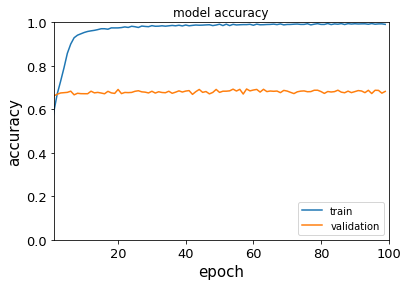

In [11]:
fig = plt.title("model accuracy")
plt.plot(train_acc)
plt.plot(val_acc)
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right")
plt.show()